(Started on 2022-04-01)

Our goal is to reuse the dataset used in VolPy to train our own segmentation algorithm.

Problem: volpy's segmentation tries to identify all the neurons present in an image, and therefore their ground truths reflect that. Our segmentation only identifies neurons that actually activate during a movie sequence. Therefore, in order to reuse VolPy datasets, we need to remove from their groundtruths the neurons it detects but that are not firing.

This notebook reproduces the VolPy pipeline and uses its results to produce a dataset that is usable to train our segmentation model.

In [4]:
# Remove margins
from IPython.core.display import display, HTML
display(HTML("""
<style>
     #notebook { padding-top:0px !important; }
     .container { width:100% !important; }
     .end_space { min-height:0px !important; }
     div.prompt { min-width:0px; }
     .prompt { min-width:0px; }
     .output_area { background-color:#eeeeee;}
  </style>"""))

In [5]:
"""
Demo pipeline for processing voltage imaging data. The processing pipeline
includes motion correction, memory mapping, segmentation, denoising and source
extraction. The demo shows how to construct the params, MotionCorrect and VOLPY 
objects and call the relevant functions. See inside for detail.
Dataset courtesy of Karel Svoboda Lab (Janelia Research Campus).
author: @caichangjia
"""
import cv2
import glob
import h5py
import logging
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os

try:
    cv2.setNumThreads(0)
except:
    pass

try:
    if __IPYTHON__:
        # this is used for debugging purposes only. allows to reload classes
        # when changed
        get_ipython().magic('load_ext autoreload')
        get_ipython().magic('autoreload 2')
except NameError:
    pass

import caiman as cm
from caiman.motion_correction import MotionCorrect
from caiman.paths import caiman_datadir
from caiman.source_extraction.volpy import utils
from caiman.source_extraction.volpy.volparams import volparams
from caiman.source_extraction.volpy.volpy import VOLPY
from caiman.summary_images import local_correlations_movie_offline
from caiman.summary_images import mean_image
from caiman.utils.utils import download_demo, download_model


/home/yves/softs/miniconda3/envs/caiman/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/yves/softs/miniconda3/envs/caiman/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/yves/softs/miniconda3/envs/caiman/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/yves/softs/miniconda3/env

In [6]:
# Set up the logger (optional); change this if you like.
# You can log to a file using the filename parameter, or make the output more
# or less verbose by setting level to logging.DEBUG, logging.INFO,
# logging.WARNING, or logging.ERROR
logging.basicConfig(format=
                    "%(relativeCreated)12d [%(filename)s:%(funcName)20s():%(lineno)s]" \
                    "[%(process)d] %(message)s",
                    level=logging.INFO)


In [7]:
# # %%  Load demo movie and ROIs
# fnames = download_demo('demo_voltage_imaging.hdf5', 'volpy')  # file path to movie file (will download if not present)
# path_ROIs = download_demo('demo_voltage_imaging_ROIs.hdf5', 'volpy')  # file path to ROIs file (will download if not present)
# file_dir = os.path.split(fnames)[0]


In [8]:
fnames = "/home/yves/Projects/active/Fixstars/datasets/VolPy_dataset/TEG.01.02/TEG.01.02.tif"
path_ROIs = "/home/yves/Projects/active/Fixstars/datasets/VolPy_dataset/TEG.01.02/TEG.01.02_ROI.zip"
file_dir = os.path.split(fnames)[0]

In [53]:
m_orig = cm.load(fnames)

In [7]:
# Play movie
ds_ratio = 0.2
moviehandle = m_orig.resize(1, 1, ds_ratio)
moviehandle.play(q_max=99.5, fr=40, magnification=4)

In [9]:
# dataset dependent parameters
fr = 400                                        # sample rate of the movie

# motion correction parameters
pw_rigid = False                                # flag for pw-rigid motion correction
gSig_filt = (3, 3)                              # size of filter, in general gSig (see below),
                                                # change this one if algorithm does not work
max_shifts = (5, 5)                             # maximum allowed rigid shift
strides = (48, 48)                              # start a new patch for pw-rigid motion correction every x pixels
overlaps = (24, 24)                             # overlap between pathes (size of patch strides+overlaps)
max_deviation_rigid = 3                         # maximum deviation allowed for patch with respect to rigid shifts
border_nan = 'copy'

opts_dict = {
    'fnames': fnames,
    'fr': fr,
    'pw_rigid': pw_rigid,
    'max_shifts': max_shifts,
    'gSig_filt': gSig_filt,
    'strides': strides,
    'overlaps': overlaps,
    'max_deviation_rigid': max_deviation_rigid,
    'border_nan': border_nan
}

opts = volparams(params_dict=opts_dict)

      305364 [volparams.py:                 set():95][29307] Changing key fnames in group data from None to /home/yves/Projects/active/Fixstars/datasets/VolPy_dataset/TEG.01.02/TEG.01.02.tif
      305365 [volparams.py:                 set():95][29307] Changing key fr in group data from None to 400
      305366 [volparams.py:                 set():95][29307] Changing key max_shifts in group motion from (6, 6) to (5, 5)
      305366 [volparams.py:                 set():95][29307] Changing key gSig_filt in group motion from None to (3, 3)
      305367 [volparams.py:                 set():95][29307] Changing key strides in group motion from (96, 96) to (48, 48)
      305367 [volparams.py:                 set():95][29307] Changing key overlaps in group motion from (32, 32) to (24, 24)


In [11]:
# %% start a cluster for parallel processing
c, dview, n_processes = cm.cluster.setup_cluster(
    backend='local', n_processes=2, single_thread=True)


In [12]:
# %%% MOTION CORRECTION
# first we create a motion correction object with the specified parameters
mc = MotionCorrect(fnames, dview=dview, **opts.get_group('motion'))
# Run correction
do_motion_correction = False
if do_motion_correction:
    mc.motion_correct(save_movie=True)
else: 
    mc_list = [file for file in os.listdir(file_dir) if 
               (os.path.splitext(os.path.split(fnames)[-1])[0] in file and '.mmap' in file)]
    mc.mmap_file = [os.path.join(file_dir, mc_list[0])]
    print(f'reuse previously saved motion corrected file:{mc.mmap_file}')


reuse previously saved motion corrected file:['/home/yves/Projects/active/Fixstars/datasets/VolPy_dataset/TEG.01.02/TEG.01.02_rig__d1_364_d2_320_d3_1_order_F_frames_10000_.mmap']


In [ ]:
# %% compare with original movie
m_orig = cm.load(fnames)
m_rig = cm.load(mc.mmap_file)
ds_ratio = 0.2
moviehandle = cm.concatenate([m_orig.resize(1, 1, ds_ratio),
                              m_rig.resize(1, 1, ds_ratio)], axis=2)
moviehandle.play(fr=40, q_max=99.5, magnification=4)  # press q to exit

In [22]:
do_memory_mapping = False
if do_memory_mapping:
    border_to_0 = 0 if mc.border_nan == 'copy' else mc.border_to_0
    # you can include the boundaries of the FOV if you used the 'copy' option
    # during motion correction, although be careful about the components near
    # the boundaries

    # memory map the file in order 'C'
    fname_new = cm.save_memmap_join(mc.mmap_file, base_name='memmap_' + os.path.splitext(os.path.split(fnames)[-1])[0],
                                    add_to_mov=border_to_0, dview=dview)  # exclude border
else: 
    mmap_list = [file for file in os.listdir(file_dir) if 
                 ('memmap_' + os.path.splitext(os.path.split(fnames)[-1])[0]) in file]
    fname_new = os.path.join(file_dir, mmap_list[0])
    print(f'reuse previously saved memory mapping file:{fname_new}')


reuse previously saved memory mapping file:/home/yves/Projects/active/Fixstars/datasets/VolPy_dataset/TEG.01.02/memmap_TEG.01.02_d1_364_d2_320_d3_1_order_C_frames_10000_.mmap


In [23]:
m_rig = cm.load(fname_new)

In [24]:
img=np.mean(m_rig, axis=0)

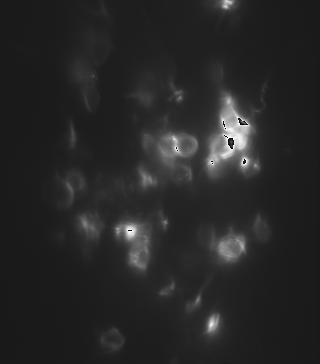

In [25]:
Image.fromarray(np.uint8(img/4))

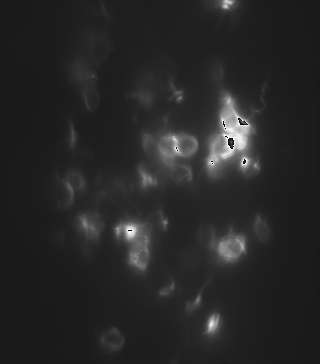

In [54]:
Image.fromarray(np.uint8(np.mean(m_orig,axis=0)/4))

In [18]:
from caiman.base.rois import nf_read_roi_zip
ROIs = nf_read_roi_zip(path_ROIs, (364, 320)) 

      364628 [rois.py:         nf_read_roi():988][29307] Magic number not found
      364629 [rois.py:         nf_read_roi():988][29307] Magic number not found
      364631 [rois.py:         nf_read_roi():988][29307] Magic number not found
      364631 [rois.py:         nf_read_roi():988][29307] Magic number not found
      364633 [rois.py:         nf_read_roi():988][29307] Magic number not found
      364634 [rois.py:         nf_read_roi():988][29307] Magic number not found
      364635 [rois.py:         nf_read_roi():988][29307] Magic number not found
      364636 [rois.py:         nf_read_roi():988][29307] Magic number not found
      364637 [rois.py:         nf_read_roi():988][29307] Magic number not found
      364639 [rois.py:         nf_read_roi():988][29307] Magic number not found
      364640 [rois.py:         nf_read_roi():988][29307] Magic number not found
      364641 [rois.py:         nf_read_roi():988][29307] Magic number not found
      364642 [rois.py:         nf_read_r

In [15]:
import numpy as np
from PIL import Image

In [36]:
from notebook_helpers import add_contours

In [44]:
m = np.uint8(img/4)
m = np.stack([m,m,m],axis=2)

In [50]:
m2 = add_contours(m, rois, color=(255,0,0))

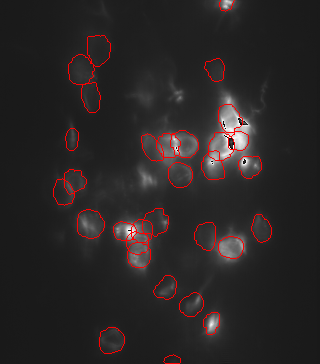

In [51]:
Image.fromarray(m2)

In [16]:
# %% restart cluster to clean up memory
cm.stop_server(dview=dview)
c, dview, n_processes = cm.cluster.setup_cluster(
    backend='local', n_processes=2, single_thread=True, maxtasksperchild=1)


      342203 [cluster.py:         stop_server():291][29307] Stopping cluster...
      342531 [cluster.py:         stop_server():334][29307] No cluster to stop...
      342532 [cluster.py:         stop_server():348][29307] stop_cluster(): done


In [19]:
ROIs = ROIs                                   # region of interests
index = list(range(len(ROIs)))                # index of neurons
weights = None                                # if None, use ROIs for initialization; to reuse weights check reuse weights block 

context_size = 35                             # number of pixels surrounding the ROI to censor from the background PCA
visualize_ROI = False                         # whether to visualize the region of interest inside the context region
flip_signal = True                            # Important!! Flip signal or not, True for Voltron indicator, False for others
hp_freq_pb = 1 / 3                            # parameter for high-pass filter to remove photobleaching
clip = 100                                    # maximum number of spikes to form spike template
threshold_method = 'adaptive_threshold'       # adaptive_threshold or simple 
min_spikes= 10                                # minimal spikes to be found
pnorm = 0.5                                   # a variable deciding the amount of spikes chosen for adaptive threshold method
threshold = 3                                 # threshold for finding spikes only used in simple threshold method, Increase the threshold to find less spikes
do_plot = False                               # plot detail of spikes, template for the last iteration
ridge_bg= 0.01                                # ridge regression regularizer strength for background removement, larger value specifies stronger regularization 
sub_freq = 20                                 # frequency for subthreshold extraction
weight_update = 'ridge'                       # ridge or NMF for weight update
n_iter = 2                                    # number of iterations alternating between estimating spike times and spatial filters

opts_dict={'fnames': fname_new,
           'ROIs': ROIs,
           'index': index,
           'weights': weights,
           'context_size': context_size,
           'visualize_ROI': visualize_ROI, 
           'flip_signal': flip_signal,
           'hp_freq_pb': hp_freq_pb,
           'clip': clip,
           'threshold_method': threshold_method,
           'min_spikes':min_spikes,
           'pnorm': pnorm, 
           'threshold': threshold,
           'do_plot':do_plot,
           'ridge_bg':ridge_bg,
           'sub_freq': sub_freq,
           'weight_update': weight_update,
           'n_iter': n_iter}

opts.change_params(params_dict=opts_dict);          


      372349 [volparams.py:                 set():95][29307] Changing key fnames in group data from /home/yves/Projects/active/Fixstars/datasets/VolPy_dataset/TEG.01.02/TEG.01.02.tif to /home/yves/Projects/active/Fixstars/datasets/VolPy_dataset/TEG.01.02/memmap_TEG.01.02_d1_364_d2_320_d3_1_order_C_frames_10000_.mmap
      372503 [volparams.py:                 set():95][29307] Changing key ROIs in group data from None to [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]


In [20]:
#%% TRACE DENOISING AND SPIKE DETECTION
vpy = VOLPY(n_processes=n_processes, dview=dview, params=opts)
vpy.fit(n_processes=n_processes, dview=dview)

Now processing cell number 0
Now processing cell number 1
Now processing cell number 2


      387825 [spikepursuit.py:     adaptive_thresh():601][29307] Few spikes were detected. Adjusting threshold to take 10 largest spikes


Now processing cell number 3
Now processing cell number 4
Now processing cell number 5
Now processing cell number 6
Now processing cell number 7


      404086 [spikepursuit.py:     adaptive_thresh():601][29307] Few spikes were detected. Adjusting threshold to take 10 largest spikes
      405004 [spikepursuit.py:     adaptive_thresh():601][29307] Few spikes were detected. Adjusting threshold to take 10 largest spikes
      405340 [spikepursuit.py:     adaptive_thresh():601][29307] Few spikes were detected. Adjusting threshold to take 10 largest spikes


Now processing cell number 8
Now processing cell number 9
Now processing cell number 10


      413959 [spikepursuit.py:     adaptive_thresh():601][29307] Few spikes were detected. Adjusting threshold to take 10 largest spikes


Now processing cell number 11
Now processing cell number 12
Now processing cell number 13


      425505 [spikepursuit.py:     adaptive_thresh():601][29307] Few spikes were detected. Adjusting threshold to take 10 largest spikes
      425848 [spikepursuit.py:     adaptive_thresh():601][29307] Few spikes were detected. Adjusting threshold to take 10 largest spikes


Now processing cell number 14


      428696 [spikepursuit.py:     adaptive_thresh():601][29307] Few spikes were detected. Adjusting threshold to take 10 largest spikes


Now processing cell number 15


      431486 [spikepursuit.py:     adaptive_thresh():601][29307] Few spikes were detected. Adjusting threshold to take 10 largest spikes


Now processing cell number 16
Now processing cell number 17


      436045 [spikepursuit.py:     adaptive_thresh():604][29307] Selecting top 100 spikes for template
      437347 [spikepursuit.py:     adaptive_thresh():601][29307] Few spikes were detected. Adjusting threshold to take 10 largest spikes


Now processing cell number 18
Now processing cell number 19


      443089 [spikepursuit.py:     adaptive_thresh():601][29307] Few spikes were detected. Adjusting threshold to take 10 largest spikes


Now processing cell number 20


      445332 [spikepursuit.py:     adaptive_thresh():601][29307] Few spikes were detected. Adjusting threshold to take 10 largest spikes


Now processing cell number 21


      448552 [spikepursuit.py:     adaptive_thresh():601][29307] Few spikes were detected. Adjusting threshold to take 10 largest spikes
      449554 [spikepursuit.py:     adaptive_thresh():601][29307] Few spikes were detected. Adjusting threshold to take 10 largest spikes


Now processing cell number 22


      451454 [spikepursuit.py:     adaptive_thresh():601][29307] Few spikes were detected. Adjusting threshold to take 10 largest spikes
      452324 [spikepursuit.py:     adaptive_thresh():601][29307] Few spikes were detected. Adjusting threshold to take 10 largest spikes


Now processing cell number 23


      455341 [spikepursuit.py:     adaptive_thresh():601][29307] Few spikes were detected. Adjusting threshold to take 10 largest spikes


Now processing cell number 24


      456793 [spikepursuit.py:     adaptive_thresh():601][29307] Few spikes were detected. Adjusting threshold to take 10 largest spikes


Now processing cell number 25


      458744 [spikepursuit.py:     adaptive_thresh():601][29307] Few spikes were detected. Adjusting threshold to take 10 largest spikes
      459340 [spikepursuit.py:     adaptive_thresh():601][29307] Few spikes were detected. Adjusting threshold to take 10 largest spikes


Now processing cell number 26


      461346 [spikepursuit.py:     adaptive_thresh():601][29307] Few spikes were detected. Adjusting threshold to take 10 largest spikes
      461434 [spikepursuit.py:     adaptive_thresh():601][29307] Few spikes were detected. Adjusting threshold to take 10 largest spikes
      462737 [spikepursuit.py:     adaptive_thresh():601][29307] Few spikes were detected. Adjusting threshold to take 10 largest spikes


Now processing cell number 27


      464273 [spikepursuit.py:     adaptive_thresh():604][29307] Selecting top 100 spikes for template
/home/yves/Projects/active/Fixstars/CaImAn/caiman/source_extraction/volpy/spikepursuit.py:609: RuntimeWarning: invalid value encountered in double_scalars
  detectionRate = (csf2[ix] - csmodel2[ix]) / np.max(csf2 - csmodel2)


Now processing cell number 28
Now processing cell number 29


      470051 [spikepursuit.py:     adaptive_thresh():604][29307] Selecting top 100 spikes for template
/home/yves/Projects/active/Fixstars/CaImAn/caiman/source_extraction/volpy/spikepursuit.py:609: RuntimeWarning: invalid value encountered in double_scalars
  detectionRate = (csf2[ix] - csmodel2[ix]) / np.max(csf2 - csmodel2)


Now processing cell number 30


      473379 [spikepursuit.py:     adaptive_thresh():604][29307] Selecting top 100 spikes for template
/home/yves/Projects/active/Fixstars/CaImAn/caiman/source_extraction/volpy/volpy.py:157: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.estimates[i] = np.array([results[j][i] for j in range(N)])


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 27 28 29 30]
Component:0


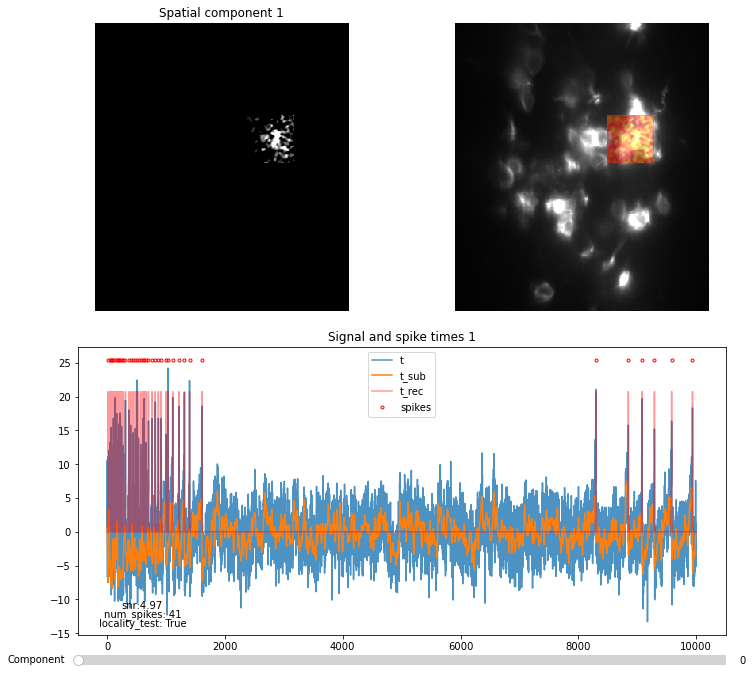

Component:0


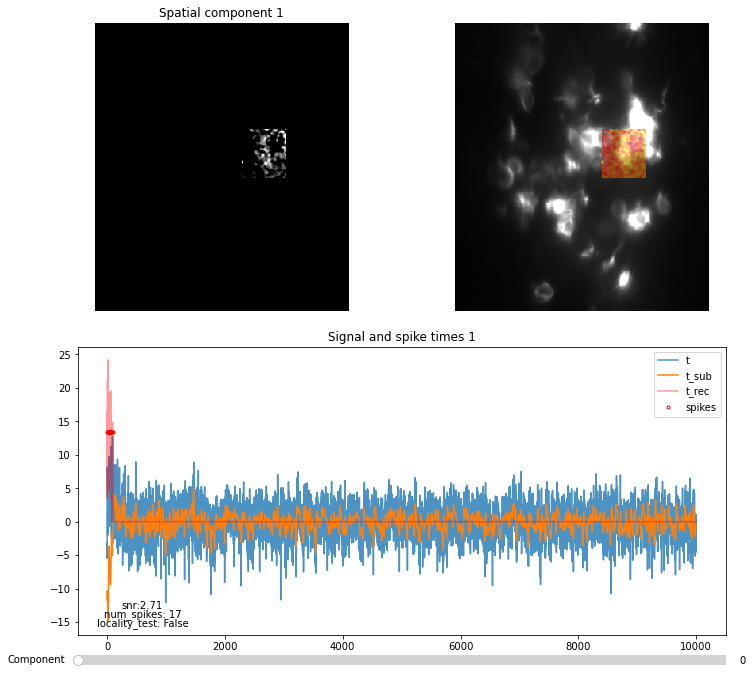

In [52]:
#%% visualization
display_images = True
if display_images:
    print(np.where(vpy.estimates['locality'])[0])    # neurons that pass locality test
    idx = np.where(vpy.estimates['locality'] > 0)[0]
    utils.view_components(vpy.estimates, img, [0])
    utils.view_components(vpy.estimates, img, [26])

In [46]:
idx

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30])

In [37]:
vpy.estimates["locality"]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True])

In [41]:
vpy.estimates["num_spikes"]

array([[ 34,  43,  41],
       [ 24,  24,  16],
       [ 30,  27,  23],
       [ 19,  21,  23],
       [ 46,  28,  30],
       [107, 111, 105],
       [ 45,  47,  50],
       [ 18,  12,  12],
       [ 41, 114, 125],
       [ 55,  33,  32],
       [ 12,  14,  14],
       [321, 117,  51],
       [171, 119,  83],
       [ 62,  76,  27],
       [ 33,  15,  18],
       [ 86,  77,  37],
       [ 59,  33,  20],
       [ 28, 110,  74],
       [ 58,  49,  72],
       [223,  52,  47],
       [208, 121,  71],
       [204,  50,  22],
       [ 20,  21,  21],
       [ 48,  79,  89],
       [ 30, 130,  79],
       [204,  77,  43],
       [ 10,  14,  17],
       [ 52,  32,  25],
       [151,  40,  37],
       [ 71,  76,  50],
       [ 71,  24,  13]])

In [40]:
ROIs.shape

(31, 364, 320)

In [2]:

   
    
#%% reconstructed movie
# note the negative spatial weights is cutoff    
    if display_images:
        mv_all = utils.reconstructed_movie(vpy.estimates.copy(), fnames=mc.mmap_file,
                                           idx=idx, scope=(0,1000), flip_signal=flip_signal)
        mv_all.play(fr=40, magnification=3)
    
#%% save the result in .npy format 
    save_result = True
    if save_result:
        vpy.estimates['ROIs'] = ROIs
        vpy.estimates['params'] = opts
        save_name = f'volpy_{os.path.split(fnames)[1][:-5]}_{threshold_method}'
        np.save(os.path.join(file_dir, save_name), vpy.estimates)
        
#%% reuse weights 
# set weights = reuse_weights in opts_dict dictionary
    estimates = np.load(os.path.join(file_dir, save_name+'.npy'), allow_pickle=True).item()
    reuse_weights = []
    for idx in range(ROIs.shape[0]):
        coord = estimates['context_coord'][idx]
        w = estimates['weights'][idx][coord[0][0]:coord[1][0]+1, coord[0][1]:coord[1][1]+1] 
        plt.figure(); plt.imshow(w);plt.colorbar(); plt.show()
        reuse_weights.append(w)
    
# %% STOP CLUSTER and clean up log files
    cm.stop_server(dview=dview)
    log_files = glob.glob('*_LOG_*')
    for log_file in log_files:
        os.remove(log_file)

# %%
# This is to mask the differences between running this demo in Spyder
# versus from the CLI
if __name__ == "__main__":
    main()

/home/yves/softs/miniconda3/envs/caiman/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/yves/softs/miniconda3/envs/caiman/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/yves/softs/miniconda3/envs/caiman/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/yves/softs/miniconda3/env

  File "/home/yves/Projects/active/Fixstars/CaImAn/caiman/motion_correction.py", line 1301, in _upsampled_dft
    output = np.tensordot(row_kernel, data, axes = [1,0])
  File "/home/yves/softs/miniconda3/envs/caiman/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/home/yves/softs/miniconda3/envs/caiman/lib/python3.7/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "/home/yves/softs/miniconda3/envs/caiman/lib/python3.7/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "/home/yves/Projects/active/Fixstars/CaImAn/caiman/motion_correction.py", line 3064, in tile_and_correct_wrapper
    use_cuda=use_cuda, border_nan=border_nan)
  File "/home/yves/softs/miniconda3/envs/caiman/lib/python3.7/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "/home/yves/Projects/active/Fixstars/CaImAn/caiman/motion_correction.py", line 3064, in tile_and_corre

Traceback (most recent call last):
  File "/home/yves/softs/miniconda3/envs/caiman/lib/python3.7/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
Process ForkPoolWorker-11:
  File "/home/yves/softs/miniconda3/envs/caiman/lib/python3.7/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
Traceback (most recent call last):
KeyboardInterrupt
  File "/home/yves/softs/miniconda3/envs/caiman/lib/python3.7/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "/home/yves/Projects/active/Fixstars/CaImAn/caiman/motion_correction.py", line 3064, in tile_and_correct_wrapper
    use_cuda=use_cuda, border_nan=border_nan)
  File "/home/yves/Projects/active/Fixstars/CaImAn/caiman/motion_correction.py", line 3064, in tile_and_correct_wrapper
    use_cuda=use_cuda, border_nan=border_nan)
Traceback (most recent call last):
  File "/home/yves/softs/miniconda3/envs/caiman/lib/python3.7/multiprocessing/process.py", line 297, in _boots

Traceback (most recent call last):
  File "/home/yves/softs/miniconda3/envs/caiman/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3524, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_27884/4103341458.py", line 280, in <module>
    main()
  File "/tmp/ipykernel_27884/4103341458.py", line 110, in main
    mc.motion_correct(save_movie=True)
  File "/home/yves/Projects/active/Fixstars/CaImAn/caiman/motion_correction.py", line 267, in motion_correct
    self.motion_correct_rigid(template=template, save_movie=save_movie)
  File "/home/yves/Projects/active/Fixstars/CaImAn/caiman/motion_correction.py", line 318, in motion_correct_rigid
    indices=self.indices)
  File "/home/yves/Projects/active/Fixstars/CaImAn/caiman/motion_correction.py", line 2839, in motion_correct_batch_rigid
    indices=indices)
  File "/home/yves/Projects/active/Fixstars/CaImAn/caiman/motion_correction.py", line 3154, in motion_correction_piecewise
    res =

TypeError: object of type 'NoneType' has no len()

Process ForkPoolWorker-15:
Traceback (most recent call last):
  File "/home/yves/softs/miniconda3/envs/caiman/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/yves/softs/miniconda3/envs/caiman/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/yves/softs/miniconda3/envs/caiman/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/yves/softs/miniconda3/envs/caiman/lib/python3.7/multiprocessing/queues.py", line 352, in get
    res = self._reader.recv_bytes()
  File "/home/yves/softs/miniconda3/envs/caiman/lib/python3.7/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/yves/softs/miniconda3/envs/caiman/lib/python3.7/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/yves/softs/miniconda3/envs/caiman/lib/python3.7/multiprocessing/connection